# 10 - Linear MHD equations

Topics covered in this tutorial:

- instance of [ShearAlfven](https://struphy.pages.mpcdf.de/struphy/sections/subsections/propagators_fields.html#struphy.propagators.propagators_fields.ShearAlfven) propagator
- instance of [Magnetosonic](https://struphy.pages.mpcdf.de/struphy/sections/subsections/propagators_fields.html#struphy.propagators.propagators_fields.Magnetosonic) propagator
- initialization with noise
- power spectrum plot
- $\theta$-pinch and $Z$-pinch configurations

We are concerned with the solution of the ideal, linearized MHD equations coded in the model [LinearMHD](https://struphy.pages.mpcdf.de/struphy/sections/subsections/models_fluid.html#struphy.models.fluid.LinearMHD):

$$
\begin{align}
 &\frac{\partial \tilde \rho}{\partial t}+\nabla\cdot(\rho_0 \tilde{\mathbf{U}})=0\,, 
        \\[2mm]
        \rho_0&\frac{\partial \tilde{\mathbf{U}}}{\partial t} + \nabla \tilde p
        = (\nabla \times \tilde{\mathbf{B}})\times \mathbf{B}_0 + (\nabla\times\mathbf{B}_0)\times \tilde{\mathbf{B}} \,,
        \\[2mm]
        &\frac{\partial \tilde p}{\partial t} + \nabla\cdot(p_0 \tilde{\mathbf{U}}) 
        + \frac{2}{3}\,p_0\nabla\cdot \tilde{\mathbf{U}}=0\,,
        \\[2mm]
        &\frac{\partial \tilde{\mathbf{B}}}{\partial t} - \nabla\times(\tilde{\mathbf{U}} \times \mathbf{B}_0)
        = 0\,.
\end{align}
$$

## MHD dispersion relation in a slab

In [1]:
# set up domain Omega
from struphy.geometry.domains import Cuboid

xL = 0.
xR = 1.
yL = 0.
yR = 1.
zL = 0.
zR = 60.
domain = Cuboid(l1=xL, r1=xR, l2=yL, r2=yR, l3=zL, r3=zR)

In [2]:
# set up MHD equilibrium
from struphy.fields_background.equils import HomogenSlab

B0x = 0.
B0y = 1.
B0z = 1.
beta = 1.
n0 = 1.
mhd_equil = HomogenSlab(B0x=B0x, B0y=B0y, B0z=B0z, beta=beta, n0=n0)

# must set domain of Cartesian MHD equilibirum
mhd_equil.domain = domain

In [3]:
# set up Derham complex
from struphy.feec.psydac_derham import Derham

Nel = [1, 1, 64]
p = [1, 1, 3]
spl_kind = [True, True, True]
derham = Derham(Nel, p, spl_kind)

In [4]:
# create solution field u in Vh_2 subset H(div) 
u_space = 'Hdiv' # choose 'H1vec' for comparison
mhd_u = derham.create_field('velocity', u_space)

# create solution field B in Vh_2 subset H(div) 
b_field = derham.create_field('magnetic field', 'Hdiv')

# create solution fields rho and p in Vh_3 subset L2 
mhd_rho = derham.create_field('mass density', 'L2')
mhd_p = derham.create_field('pressure', 'L2')

In [5]:
# initial perturbations
pert_params_u = {"noise": {'comps' : [True, True, True],
                           'direction' : 'e3',
                           'amp' : 0.1, 
                           'seed' : None,}}

In [6]:
mhd_u.initialize_coeffs(pert_params=pert_params_u)
b_field.initialize_coeffs()
mhd_rho.initialize_coeffs()
mhd_p.initialize_coeffs()

In [7]:
# evalaute at logical coordinates
import numpy as np

e1 = .5
e2 = .5
e3 = np.linspace(0, 1, 100)

u_vals = mhd_u(e1, e2, e3, squeeze_out=True)
b_vals = b_field(e1, e2, e3, squeeze_out=True)

<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\h'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\h'
<>:17: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_130454/982825109.py:9: SyntaxWarning: invalid escape sequence '\h'
  plt.title(f'$\hat u^{2 if u_space == "Hdiv2" else " "}_{i + 1}$')
/tmp/ipykernel_130454/982825109.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\eta_3$')
/tmp/ipykernel_130454/982825109.py:16: SyntaxWarning: invalid escape sequence '\h'
  plt.title(f'$\hat b^2_{i + 1}$')
/tmp/ipykernel_130454/982825109.py:17: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\eta_3$')


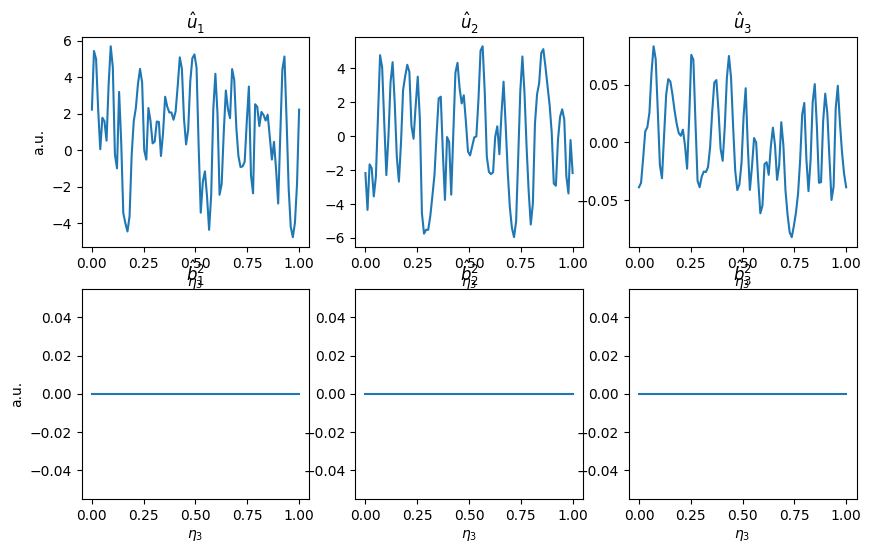

In [8]:
# plot inital conditions

from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.plot(e3, u_vals[i])
    plt.title(f'$\hat u^{2 if u_space == "Hdiv2" else " "}_{i + 1}$')
    plt.xlabel('$\eta_3$')
    if i == 0:
        plt.ylabel('a.u.')
        
    plt.subplot(2, 3, i + 4)
    plt.plot(e3, b_vals[i])
    plt.title(f'$\hat b^2_{i + 1}$')
    plt.xlabel('$\eta_3$')
    if i == 0:
        plt.ylabel('a.u.')

In [9]:
# set up mass matrices
from struphy.feec.mass import WeightedMassOperators

mass_ops = WeightedMassOperators(derham, domain, eq_mhd=mhd_equil)

In [10]:
# set up basis projection operators
from struphy.feec.basis_projection_ops import BasisProjectionOperators

basis_ops = BasisProjectionOperators(derham, domain, eq_mhd=mhd_equil)

In [11]:
# pass simulation parameters to Propagators
from struphy.propagators.base import Propagator

Propagator.derham = derham
Propagator.domain = domain
Propagator.mass_ops = mass_ops
Propagator.basis_ops = basis_ops

In [12]:
from struphy.propagators.propagators_fields import ShearAlfven, Magnetosonic

# default parameters of Propagator
opts = ShearAlfven.options(default=True)
opts

{'algo': 'implicit',
 'solver': {'type': ('pcg', 'MassMatrixDiagonalPreconditioner'),
  'tol': 1e-08,
  'maxiter': 3000,
  'info': False,
  'verbose': False,
  'recycle': True},
 'turn_off': False}

In [13]:
# default parameters of Propagator
opts = Magnetosonic.options(default=True)
opts

{'solver': {'type': ('pbicgstab', 'MassMatrixPreconditioner'),
  'tol': 1e-08,
  'maxiter': 3000,
  'info': False,
  'verbose': False,
  'recycle': True},
 'turn_off': False}

In [14]:
prop_1 = ShearAlfven(mhd_u.vector, b_field.vector, u_space=u_space)
prop_1_explicit = ShearAlfven(mhd_u.vector, b_field.vector, u_space=u_space, algo="rk4")


Assembling matrix of WeightedMassOperator "M2n" with V=Hdiv, W=Hdiv.
Assemble block (0, 0)
Assemble block (0, 1)
Assemble block (0, 2)
Assemble block (1, 0)
Assemble block (1, 1)
Assemble block (1, 2)
Assemble block (2, 0)
Assemble block (2, 1)
Assemble block (2, 2)
Done.
Assembling BasisProjectionOperator "T2" with V=Hdiv, W=Hcurl.
Done.

Assembling matrix of WeightedMassOperator "M2" with V=Hdiv, W=Hdiv.
Assemble block (0, 0)
Assemble block (0, 1)
Assemble block (0, 2)
Assemble block (1, 0)
Assemble block (1, 1)
Assemble block (1, 2)
Assemble block (2, 0)
Assemble block (2, 1)
Assemble block (2, 2)
Done.


In [15]:
prop_2 = Magnetosonic(mhd_rho.vector,
                      mhd_u.vector,
                      mhd_p.vector,
                      u_space=u_space,
                      b=b_field.vector)

Assembling BasisProjectionOperator "S2" with V=Hdiv, W=Hdiv.
Done.
Assembling BasisProjectionOperator "K3" with V=L2, W=L2.
Done.

Assembling matrix of WeightedMassOperator "M3" with V=L2, W=L2.
Assemble block (0, 0)
Done.

Assembling matrix of WeightedMassOperator "M2J" with V=Hdiv, W=Hdiv.
Assemble block (0, 0)
Assemble block (0, 1)
Assemble block (0, 2)
Assemble block (1, 0)
Assemble block (1, 1)
Assemble block (1, 2)
Assemble block (2, 0)
Assemble block (2, 1)
Assemble block (2, 2)
Done.
Assembling BasisProjectionOperator "Q2" with V=Hdiv, W=Hdiv.
Done.


In [16]:
# time stepping, with both propagators
Tend = 180. - 1e-6
dt = .15

u_of_t = {}
p_of_t = {}
time = 0.
n = 0
while time < Tend:
    n += 1
    
    # advance in time
    prop_1(dt)
    prop_2(dt)
    time += dt
    
    # evaluate solution 
    u_of_t[time] = mhd_u(e1, e2, e3)
    p_of_t[time] = [mhd_p(e1, e2, e3)]
    
    if n % 100 == 0:
        print(f'{n}/{int(np.ceil(Tend/dt))} steps completed.')

100/1200 steps completed.
200/1200 steps completed.
300/1200 steps completed.
400/1200 steps completed.
500/1200 steps completed.
600/1200 steps completed.
700/1200 steps completed.
800/1200 steps completed.
900/1200 steps completed.
1000/1200 steps completed.
1100/1200 steps completed.
1200/1200 steps completed.


In [17]:
# reset initial condition
mhd_u.initialize_coeffs(pert_params=pert_params_u)
b_field.initialize_coeffs()

Attention: overwriting perturbation parameters for velocity


In [18]:
# time stepping, with both propagators
Tend = 180. - 1e-6
dt = .15

u_of_t_ex = {}
p_of_t_ex = {}
time = 0.
n = 0
while time < Tend:
    n += 1
    
    # advance in time
    prop_1_explicit(dt)
    prop_2(dt)
    time += dt
    
    # evaluate solution 
    u_of_t_ex[time] = mhd_u(e1, e2, e3)
    p_of_t_ex[time] = [mhd_p(e1, e2, e3)]
    
    if n % 100 == 0:
        print(f'{n}/{int(np.ceil(Tend/dt))} steps completed.')

100/1200 steps completed.
200/1200 steps completed.
300/1200 steps completed.
400/1200 steps completed.
500/1200 steps completed.
600/1200 steps completed.
700/1200 steps completed.
800/1200 steps completed.
900/1200 steps completed.
1000/1200 steps completed.
1100/1200 steps completed.
1200/1200 steps completed.


code: notebook tutorial
time step: 0.15
space step: 0.6060606060606061


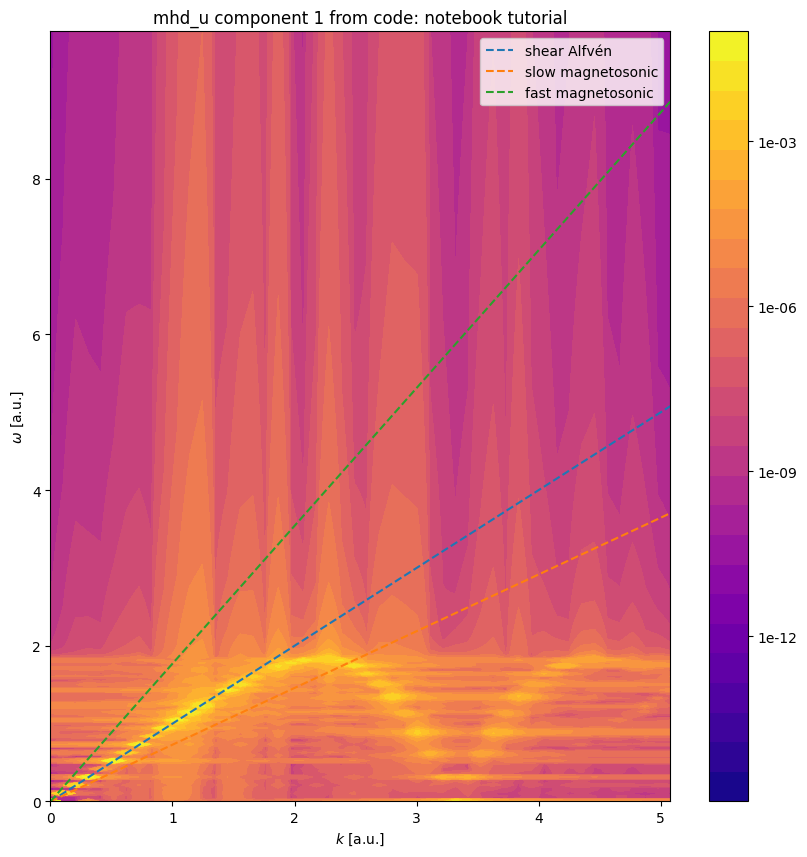

In [19]:
from struphy.diagnostics.diagn_tools import power_spectrum_2d

x, y, z = domain(e1, e2, e3)

# equilibrium pressure
p0 = beta * (B0x**2 + B0y**2 + B0z**2) / 2

disp_params = {'B0x': B0x,
               'B0y': B0y,
               'B0z': B0z,
               'p0': p0,
               'n0': n0,
               'gamma': 5/3}

# fft in (t, z) of first component of e_field on physical grid
power_spectrum_2d(u_of_t,
                  'mhd_u',
                  'notebook tutorial',
                  grids=[e1, e2, e3],
                  grids_mapped=[x, y, z],
                  component=0,
                  slice_at=[0, 0, None],
                  do_plot=True,
                  disp_name='MHDhomogenSlab',
                  disp_params=disp_params)

code: notebook tutorial
time step: 0.15
space step: 0.6060606060606061


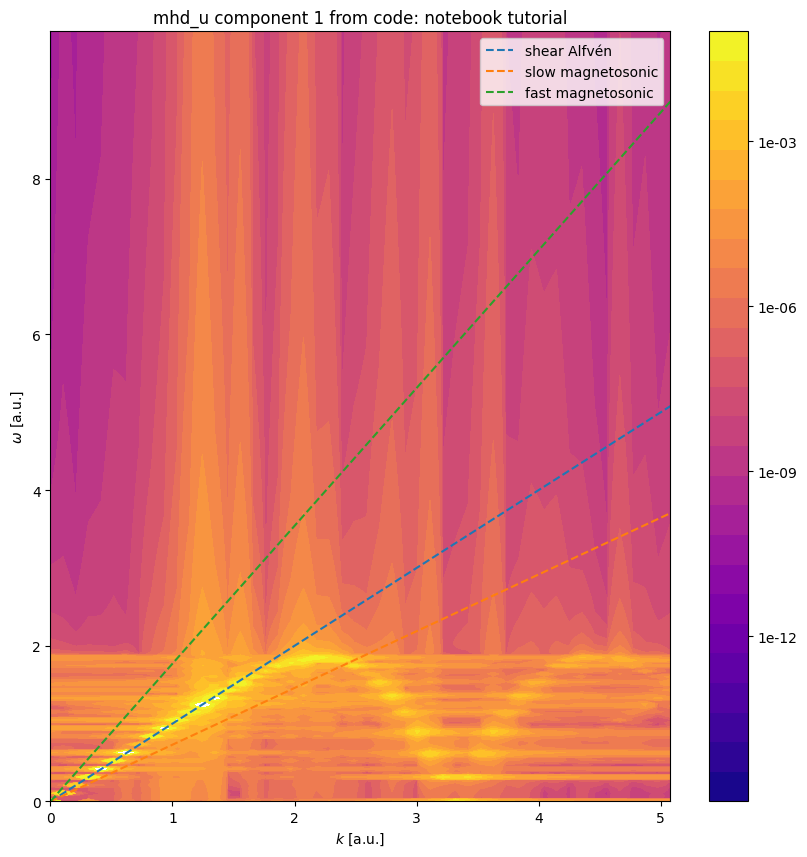

In [20]:
from struphy.diagnostics.diagn_tools import power_spectrum_2d

x, y, z = domain(e1, e2, e3)

# equilibrium pressure
p0 = beta * (B0x**2 + B0y**2 + B0z**2) / 2

disp_params = {'B0x': B0x,
               'B0y': B0y,
               'B0z': B0z,
               'p0': p0,
               'n0': n0,
               'gamma': 5/3}

# fft in (t, z) of first component of e_field on physical grid
power_spectrum_2d(u_of_t_ex,
                  'mhd_u',
                  'notebook tutorial',
                  grids=[e1, e2, e3],
                  grids_mapped=[x, y, z],
                  component=0,
                  slice_at=[0, 0, None],
                  do_plot=True,
                  disp_name='MHDhomogenSlab',
                  disp_params=disp_params)

code: notebook tutorial
time step: 0.15
space step: 0.6060606060606061


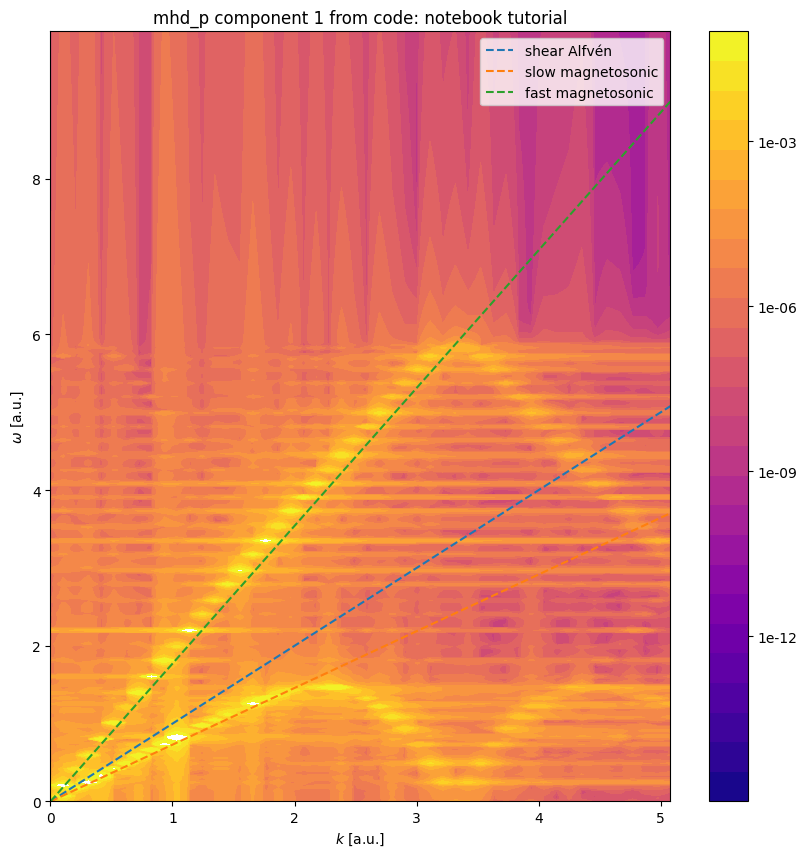

In [21]:
power_spectrum_2d(p_of_t,
                  'mhd_p',
                  'notebook tutorial',
                  grids=[e1, e2, e3],
                  grids_mapped=[x, y, z],
                  component=0,
                  slice_at=[0, 0, None],
                  do_plot=True,
                  disp_name='MHDhomogenSlab',
                  disp_params=disp_params)

code: notebook tutorial
time step: 0.15
space step: 0.6060606060606061


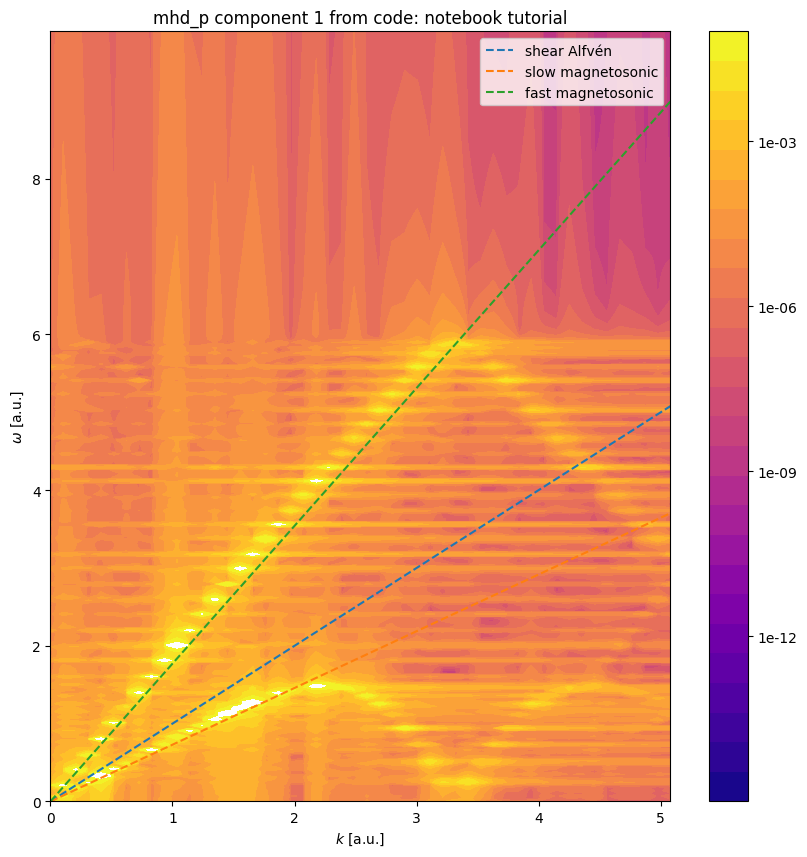

In [32]:
power_spectrum_2d(p_of_t_ex,
                  'mhd_p',
                  'notebook tutorial',
                  grids=[e1, e2, e3],
                  grids_mapped=[x, y, z],
                  component=0,
                  slice_at=[0, 0, None],
                  do_plot=True,
                  disp_name='MHDhomogenSlab',
                  disp_params=disp_params)

## $\theta$-pinch stability

Under construction ...

## $Z$-pinch stability

Under construction ...

## Screw-pinch modes

In [22]:
# set up domain Omega
from struphy.geometry.domains import HollowCylinder

a = 1
R0 = 3

a1 = 0. + 1e-6
a2 = a
Lz = 2*np.pi*R0
domain = HollowCylinder(a1=a1, a2=a2, Lz=Lz)

In [23]:
# set up MHD equilibrium
from struphy.fields_background.equils import ScrewPinch

mhd_equil = ScrewPinch(a=a, R0=R0)

# must set domain of Cartesian MHD equilibirum
mhd_equil.domain = domain

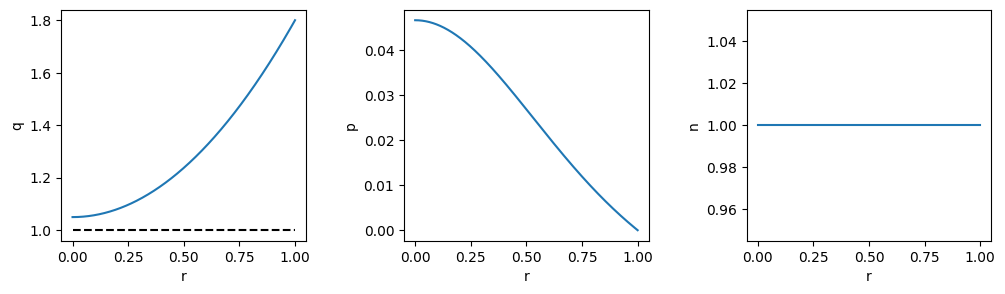

In [24]:
mhd_equil.plot_profiles()

Evaluation of mapping done.
Computation of pressure done.
Computation of density done.
Computation of abs(B) done.
Computation of current density done.
Generation of vtk files done.

Equilibrium parameters:
a :  1
R0 :  3
B0 :  1.0
q0 :  1.05
q1 :  1.8
n1 :  0.0
n2 :  0.0
na :  1.0
p0 :  1e-08
beta :  0.1

Mapping parameters:
a1 :  1e-06
a2 :  1
Lz :  18.84955592153876
poc :  1.0


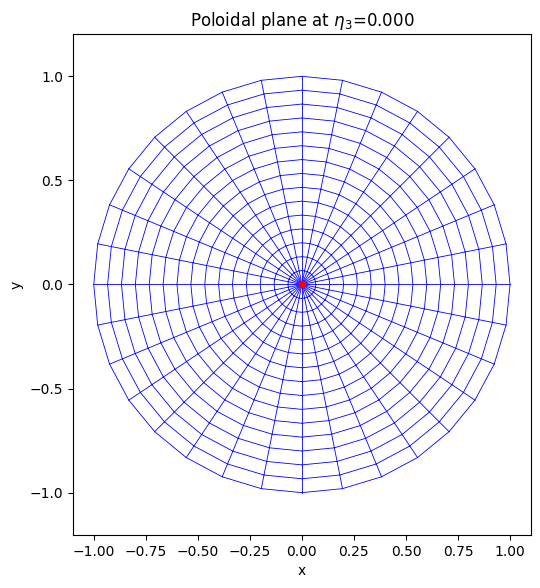

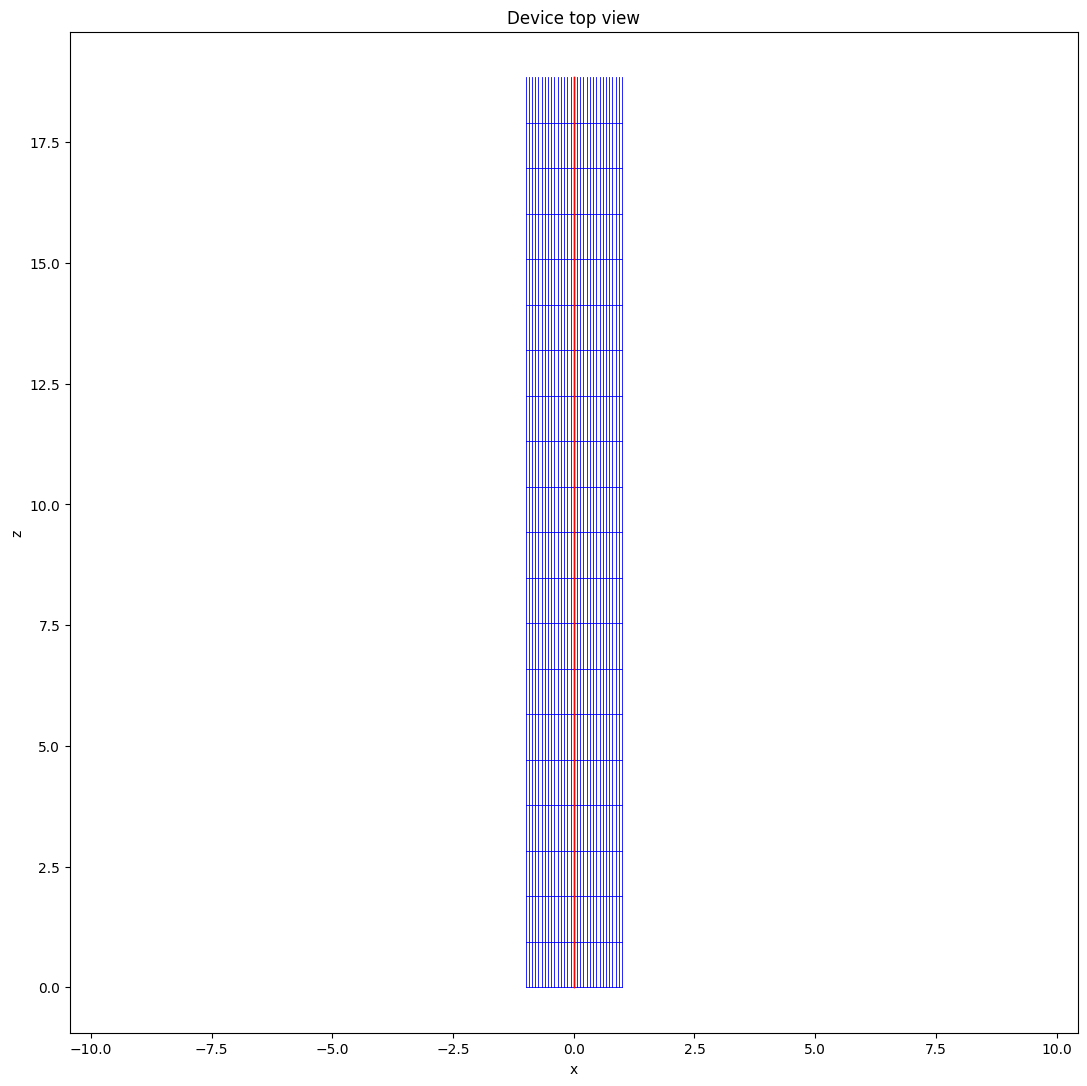

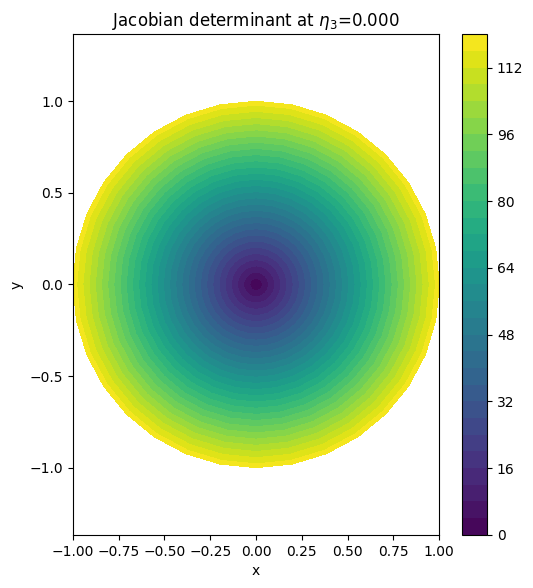

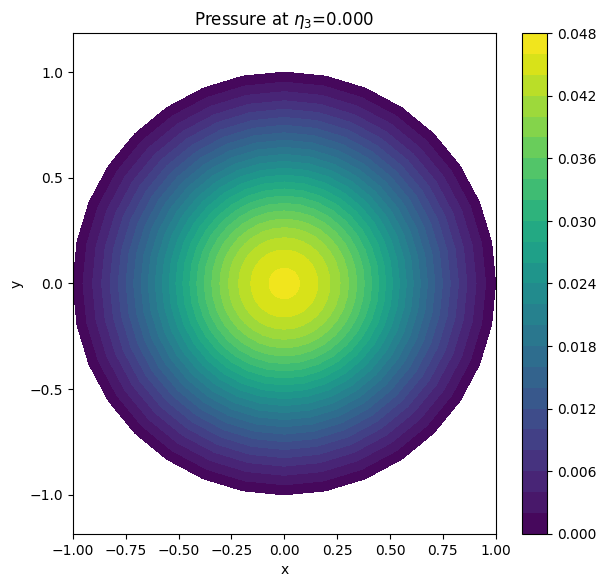

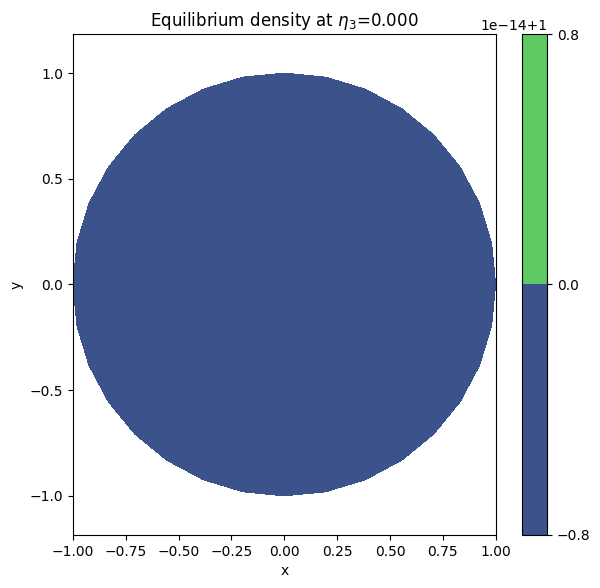

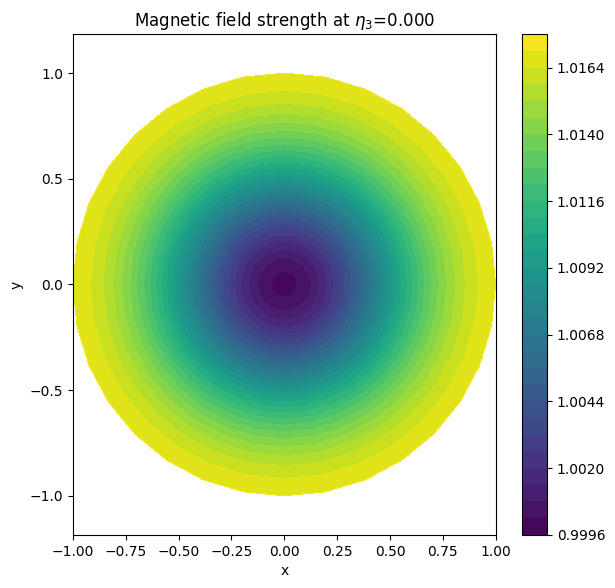

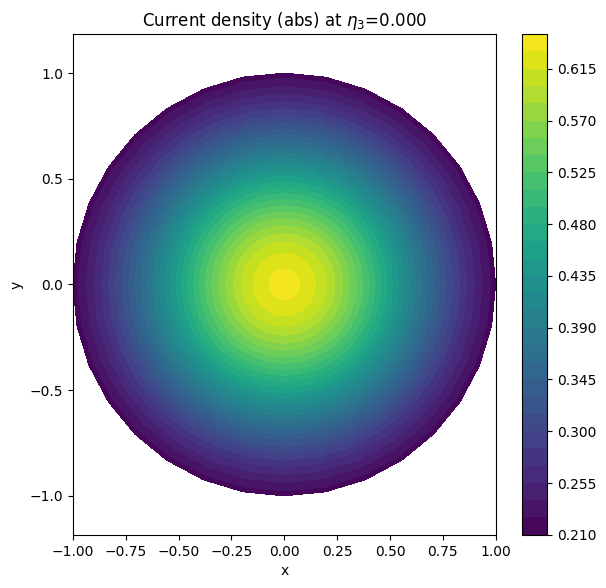

In [25]:
mhd_equil.show()

In [26]:
# set up Derham complex
from struphy.feec.psydac_derham import Derham

Nel = [16, 32, 8]
p = [1, 1, 1]
spl_kind = [False, True, True]
derham = Derham(Nel, p, spl_kind)

# ..under construction

In [27]:
# # initial perturbations
# pert_params = {}
# pert_params['type'] = 'ModesCos'

# noise_params = {
#             'comps' : {
#                 'velocity' : [True, True, True],   
#             },
#             'direction' : 'e3',
#             'amp' : 0.1, 
#             'seed' : None,
# }

# pert_params['noise'] = noise_params
# pert_params

In [28]:
# # create solution field u in Vh_2 subset H(div) 
# u_space = 'Hdiv' # choose 'H1vec' for comparison
# mhd_u = derham.create_field('velocity', u_space, pert_params=pert_params)

# # create solution field B in Vh_2 subset H(div) 
# b_field = derham.create_field('magnetic field', 'Hdiv', pert_params=pert_params)

# # create solution fields rho and p in Vh_3 subset L2 
# mhd_rho = derham.create_field('mass density', 'L2', pert_params=pert_params)
# mhd_p = derham.create_field('pressure', 'L2', pert_params=pert_params)

In [29]:
# mhd_u.initialize_coeffs()
# b_field.initialize_coeffs()
# mhd_rho.initialize_coeffs()
# mhd_p.initialize_coeffs()

In [30]:
# # evalaute at logical coordinates
# import numpy as np

# e1 = .5
# e2 = .5
# e3 = np.linspace(0, 1, 100)

# u_vals = mhd_u(e1, e2, e3, squeeze_out=True)
# b_vals = b_field(e1, e2, e3, squeeze_out=True)

In [31]:
# # plot inital conditions

# from matplotlib import pyplot as plt

# plt.figure(figsize=(10, 6))
# for i in range(3):
#     plt.subplot(2, 3, i + 1)
#     plt.plot(e3, u_vals[i])
#     plt.title(f'$\hat u^{2 if u_space == "Hdiv2" else " "}_{i + 1}$')
#     plt.xlabel('$\eta_3$')
#     if i == 0:
#         plt.ylabel('a.u.')
        
#     plt.subplot(2, 3, i + 4)
#     plt.plot(e3, b_vals[i])
#     plt.title(f'$\hat b^2_{i + 1}$')
#     plt.xlabel('$\eta_3$')
#     if i == 0:
#         plt.ylabel('a.u.')